# Notes
Assumptions:

---

Time Constraints:
Nonprofit is trying to generate interest for gala happening around the beggining of the summer, we assume street teams would be out canvassing in the three preceding months. March - Mid June.

Counter Values: Assume 'entries' and 'exits' columns reflect cumulative counts that could only increase as time moved forward. Thus, we removed any rows with negative values in differential columns and values greater than 100000 (Approximately X% of the rows)

Target Metrics:
Did not differentiate between entries and exits for a station, but rather relied on 'total_traffic' to determine which station would have the most foot traffic at a given time.

Steps:
- Read data from turnstile
- Preprocess Data




In [1]:
#Import required packages
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

In [2]:
#Reads files in turnstile directory into a files list 
from os import listdir
from os.path import isfile, join
files = [f for f in listdir('./Data/Turnstile_data') if isfile(join('./Data/Turnstile_data', f))]

In [3]:
# Create initial DataFrame
dfs = pd.DataFrame()
for file in files:
    print("Loading {}".format(str("./Data/Turnstile_data/"+file)))
    df = pd.read_csv('./Data/Turnstile_data/' + file)
    dfs = dfs.append(df)    

dfs.info()  
initial_shape = dfs.shape

Loading ./Data/Turnstile_data/turnstile_160305.txt
Loading ./Data/Turnstile_data/turnstile_160312.txt
Loading ./Data/Turnstile_data/turnstile_160319.txt
Loading ./Data/Turnstile_data/turnstile_160326.txt
Loading ./Data/Turnstile_data/turnstile_160402.txt
Loading ./Data/Turnstile_data/turnstile_160409.txt
Loading ./Data/Turnstile_data/turnstile_160416.txt
Loading ./Data/Turnstile_data/turnstile_160423.txt
Loading ./Data/Turnstile_data/turnstile_160430.txt
Loading ./Data/Turnstile_data/turnstile_160507.txt
Loading ./Data/Turnstile_data/turnstile_160514.txt
Loading ./Data/Turnstile_data/turnstile_160521.txt
Loading ./Data/Turnstile_data/turnstile_160528.txt
Loading ./Data/Turnstile_data/turnstile_160604.txt
Loading ./Data/Turnstile_data/turnstile_160611.txt
Loading ./Data/Turnstile_data/turnstile_160618.txt
Loading ./Data/Turnstile_data/turnstile_170304.txt
Loading ./Data/Turnstile_data/turnstile_170311.txt
Loading ./Data/Turnstile_data/turnstile_170318.txt
Loading ./Data/Turnstile_data/t

In [4]:
#Function to preprocess data
def preprocess(df):
    #Standardize column names
    df.columns = df.columns.str.strip()
    
    #Change Time Column to datetime format and round to nearest hour
    df['TIME'] = pd.to_datetime(df.TIME, format="%H:%M:%S").dt.round('H')
    df['TIME'] = pd.to_datetime(df.TIME, format="%H:%M:%S").dt.time
    
    #Standardize dates, replace dates not in format MM/DD/YEAR to NaN and remove those rows
    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y', errors='coerce')
    df.dropna(inplace=True)
    
    #Create day of week 'DOW' column from data column
    dfs['DOW'] = df['DATE'].dt.weekday_name
       
    #Drop Unncessary columns
    df = df.drop(['C/A','UNIT','LINENAME', 'DIVISION', 'DATE'], axis=1)   
    
    prior_shape = df.shape
    
    # Remove non 'REGULAR' audits from Desc column 
    df.drop(df.DESC != 'REGULAR', inplace = True)
    
    post_shape = df.shape
    desc_rows_removed_perc = (prior_shape[0]-post_shape[0]) / prior_shape[0]  * 100

    print("Percentage of Non Regular Data Removed  = {:08.6f} %".format(desc_rows_removed_perc))
    
    return df

In [5]:
df = preprocess(dfs)

Percentage of Non Regular Data Removed  = 0.001038 %


In [6]:
#Entry and exit data are cumulative, need to adjust to periodic interval counts.
df['DIFFS_ENTRIES'] = df['ENTRIES'].diff()
df['DIFFS_EXIT'] = df['EXITS'].diff()

In [7]:
#Remove turnstile Data in DIFFS_ENTRIES and DIFFS_EXITS that is less than zero and greater than 1e5 (Borderline)
negative_diff_entries = df['DIFFS_ENTRIES'] < 0
df.loc[negative_diff_entries,'DIFFS_ENTRIES'] = np.nan

large_diff_entries =  df['DIFFS_ENTRIES'] > 1e5
df.loc[large_diff_entries,'DIFFS_ENTRIES'] = np.nan

negative_diff_exits = df['DIFFS_EXIT'] < 0
df.loc[negative_diff_exits,'DIFFS_EXIT'] = np.nan

large_diff_exits =  df['DIFFS_EXIT'] > 1e5
df.loc[large_diff_exits,'DIFFS_EXIT'] = np.nan

In [8]:
#Add Column with Total Number of Individuals Entering and Exiting the Station
df['TOTAL_TRAFFIC'] = df['DIFFS_ENTRIES'] + df['DIFFS_EXIT']

In [9]:
#Remove Unused Data Columns
df.drop(['SCP','DESC','ENTRIES', 'EXITS', 'DIFFS_ENTRIES','DIFFS_EXIT'], axis=1, inplace=True)

In [10]:
#Percent of data equal to NaN
nulls = df['TOTAL_TRAFFIC'].isnull()
percent_null = len(df.loc[nulls,'TOTAL_TRAFFIC']) / len(df)
f'{percent_null:.2%} of the data is not useable'

'3.38% of the data is not useable'

In [11]:
#Remove Rows with NaN Values that are unusable
df.dropna(inplace=True)

In [12]:
#Assumption
#1-Remove Time Between Midnight and 7 am
even_am = datetime.time(11,0,0)
midnight = datetime.time(0,0,0)
df = df.loc[(df.TIME >= even_am) | (df.TIME == midnight)]

In [13]:
#df.sort_values(['STATION','TIME','TOTAL_TRAFFIC'], ascending=[False, False,False])

In [14]:
df_station_by_traffic_sum = df.groupby(['STATION'])[['TOTAL_TRAFFIC']].sum()

In [15]:
top_10_list_Total_Traffic = df_station_by_traffic_sum.sort_values(by=['TOTAL_TRAFFIC'], ascending = False)[0:10]

In [16]:
df_station_by_traffic_3_month_yearly_average = df.groupby(['STATION'])[['TOTAL_TRAFFIC']].sum()/3

In [17]:
top_10_list_3_month_yearly_Traffic =df_station_by_traffic_3_month_yearly_average.sort_values(by=['TOTAL_TRAFFIC'], ascending = False)[0:10]

In [18]:
#Y-AXIS Ticks of Top Stations
top10_sum = [i for i in top_10_list_Total_Traffic.index]
top10_avg = [i for i in top_10_list_3_month_yearly_Traffic.index]

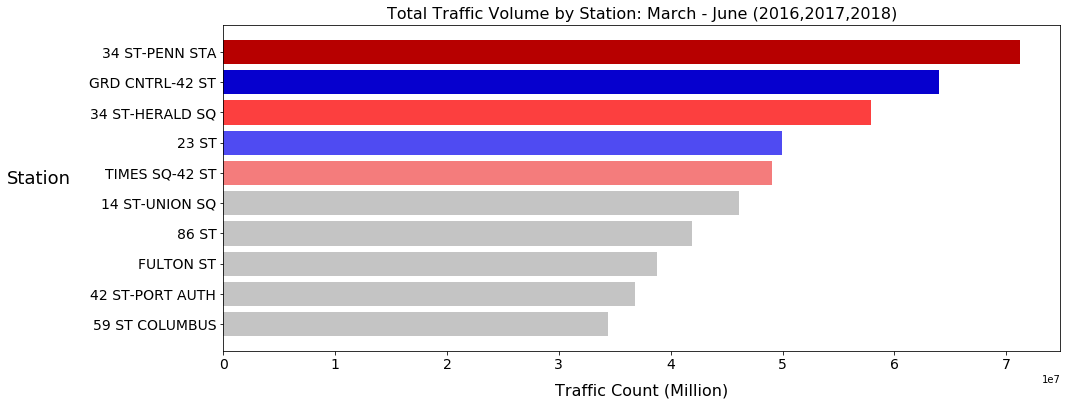

In [19]:
#Identified top 10 stations by volume of turnstile entries and exits
#Source for reference -> https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
#TODO: Remove Scientific Notation, Increase X-Axis Tick Mark
colorlist = ['#b70000','#0600ce','#fc3f3f','#4f4bf2','#f47c7c','#c4c4c4','#c4c4c4','#c4c4c4','#c4c4c4','#c4c4c4']
fig, ax = plt.subplots(1, figsize=(15, 6))
y_pos = np.arange(10)
ax.set_yticks(y_pos)
ax.set_yticklabels(top10_sum, fontsize = 14)
ax.set_ylabel('Station',fontsize = 18,rotation = 0)
ax.yaxis.set_label_coords(-.22,.5)
ax.set_xlabel('Traffic Count (Million)',fontsize=16)
ax.xaxis.set_label_coords(.5,-.1)
#ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.barh(y_pos, top_10_list_Total_Traffic['TOTAL_TRAFFIC'], color=colorlist, align='center')
ax.invert_yaxis();
plt.title('Total Traffic Volume by Station: March - June (2016,2017,2018)', fontsize=16);
ax.tick_params(labelsize=14)

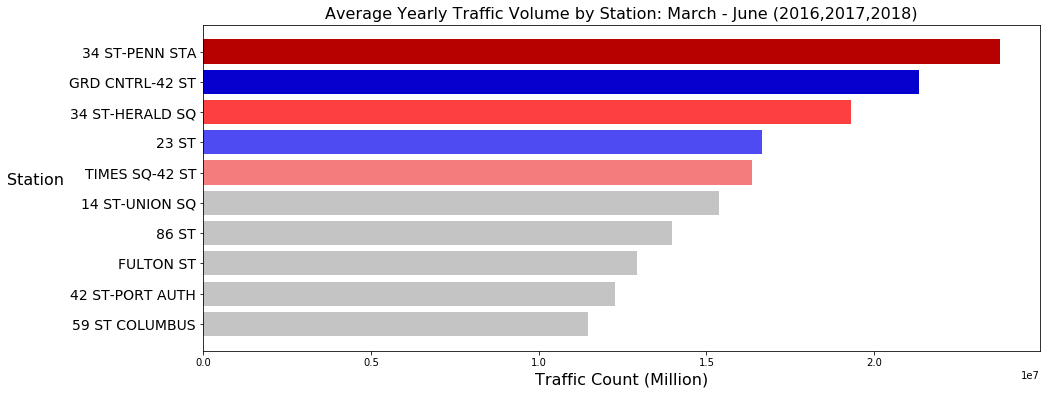

In [20]:
#TODO: Remove Scientific Notation, Increase X-Axis Tick Mark
#Identified top 10 stations by volume of turnstile entries and exits
#Source for reference -> https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
colorlist = ['#b70000','#0600ce','#fc3f3f','#4f4bf2','#f47c7c','#c4c4c4','#c4c4c4','#c4c4c4','#c4c4c4','#c4c4c4']
fig, ax = plt.subplots(1, figsize=(15, 6))
y_pos = np.arange(10)
ax.set_yticks(y_pos)
ax.set_yticklabels(top10_avg, fontsize = 14)
ax.set_ylabel('Station',fontsize = 16,rotation = 0)
ax.yaxis.set_label_coords(-.2,.5)
ax.set_xlabel('Traffic Count (Million)',fontsize=16)
#ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.barh(y_pos, top_10_list_3_month_yearly_Traffic['TOTAL_TRAFFIC'], color=colorlist, align='center')
ax.invert_yaxis();
plt.title('Average Yearly Traffic Volume by Station: March - June (2016,2017,2018)', fontsize=16);

In [21]:
#Group data by station and day of week to find average daily visitors per station. 
#Reset index of new dataframe to be used to extract top ten stations.
average_daily_station_entries = df.groupby(['STATION','DOW']).mean()[['TOTAL_TRAFFIC']].reset_index()

In [22]:
#Generate Data frame with top 10 stations
average_daily_total_per_station= average_daily_station_entries[average_daily_station_entries['STATION'].isin(top10_sum)].copy()

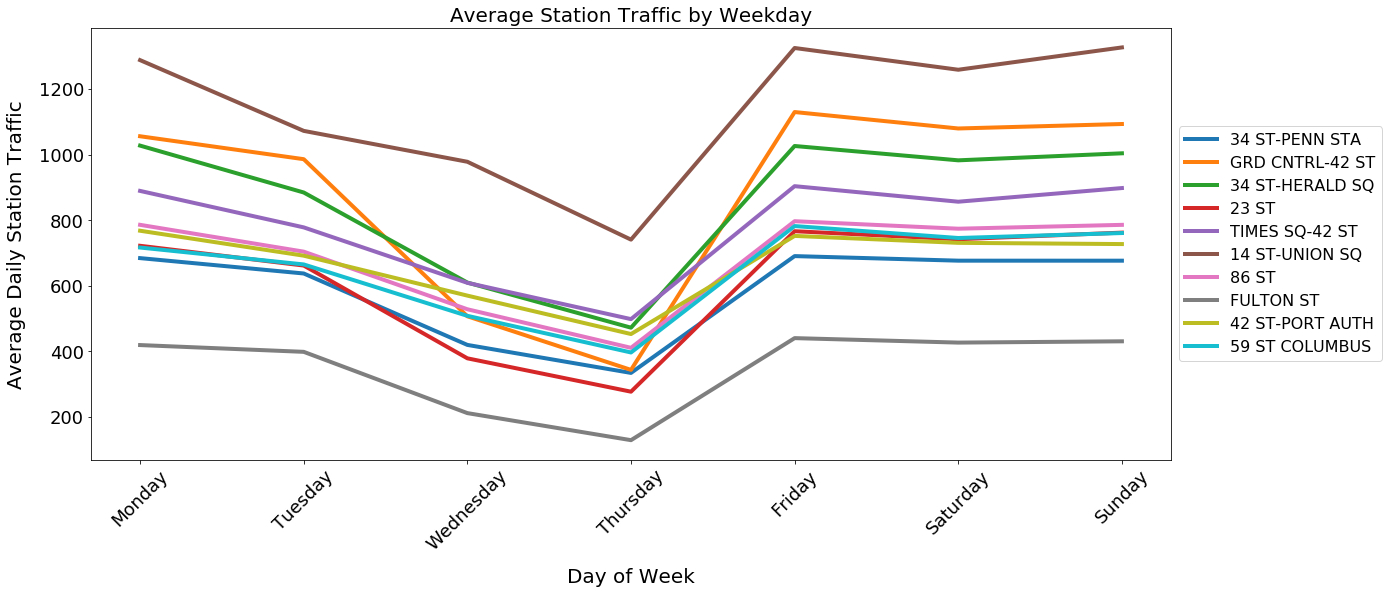

In [23]:
#TODO: Figure out why days do not appear on the graph
# for each station, plot the traffic by weekday
weekday_list = ['','Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig = plt.figure(figsize = (15, 6))

x = range(0,7)
axes = fig.add_axes([0, 0, 1, 1])

for station in top10_sum:
    y = average_daily_total_per_station[average_daily_total_per_station['STATION'] == station]['TOTAL_TRAFFIC']
    axes.plot(x, y, label = station, linewidth=4.0)
    

axes.set_xlabel('Day of Week', fontsize = 20)
axes.set_ylabel('Average Daily Station Traffic', fontsize = 20)
axes.set_title('Average Station Traffic by Weekday', fontsize = 20)
axes.set_xticklabels(weekday_list,rotation=45, fontsize = 18)
axes.yaxis.set_label_coords(-.06,.5)
axes.xaxis.set_label_coords(.5,-0.25)
axes.legend(fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5));
axes.tick_params(labelsize=18)